# Ch 2 of Montgomery and Peck

In [197]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = (12, 10)
import pandas as pd
import statsmodels.formula.api as sm
from scipy.stats import t as students_t
from scipy.stats import f as fdist

Populating the interactive namespace from numpy and matplotlib


## Rocket propellant dataset

%%file rocket-propellant-data.csv
"Observation" "Shear Strength (psi)" "Age of Propellant (weeks)"
1 2158.70 15.50
2 1678.15 23.75
3 2316.00 8.00
4 2061.30 17.00
5 2207.50 5.50
6 1708.30 19.00
7 1784.70 24.00
8 2575.00 2.50
9 2357.90 7.50
10 2256.70 11.00
11 2165.20 13.00
12 2399.55 3.75
13 1779.80 25.00
14 2336.75 9.75
15 1765.30 22.00
16 2053.50 18.00
17 2414.40 6.00
18 2200.50 12.50
19 2654.20 2.00
20 1753.70 21.50

In [70]:
prop = pd.read_csv('rocket-propellant-data.csv', sep=' ', index_col='Observation')
prop.columns = ['shear_strength', 'age'] # have to rename columns to use formulas

In [183]:
# Perform least-squares fitting to model using statsmodels
prop_fit = sm.ols(formula='shear_strength ~ age', data=prop).fit()
prop['fit'] = prop_fit.predict() # add predictions to original data
prop_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.896   
Dependent Variable: shear_strength   AIC:                241.2684
Date:               2015-08-02 22:59 BIC:                243.2599
No. Observations:   20               Log-Likelihood:     -118.63 
Df Model:           1                F-statistic:        165.4   
Df Residuals:       18               Prob (F-statistic): 1.64e-10
R-squared:          0.902            Scale:              9236.4  
-----------------------------------------------------------------
             Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-----------------------------------------------------------------
Intercept  2627.8224  44.1839  59.4746 0.0000 2534.9954 2720.6493
age         -37.1536   2.8891 -12.8599 0.0000  -43.2234  -31.0838
-----------------------------------------------------------------
Omnibus:               6.304        Durbin-Watson:          1.842
Prob(Omnibus):         0.043        Jarque-Bera (JB):       4.281
Skew:                  -1.109       Prob(JB):               0.118
Kurtosis:              3.464        Condition No.:          32   
=================================================================

"""

It looks like I get slightly different values for the estimated variance. The fitted parameters are identical to within experimental error.

In [181]:
print('SSe = {:.2f}'.format(prop_fit.mse_resid * prop_fit.df_resid))
print('MSe = {:.2f}'.format(prop_fit.mse_resid))

SSe = 166254.86
MSe = 9236.38


In [288]:
# add confidence bands at 95%
alpha = 0.01
t = students_t.isf(alpha/2, prop_fit.df_resid)
conf_lower = prop.fit - t*np.sqrt(prop_fit.mse_resid*(1/prop_fit.nobs + (prop.age - prop.age.mean())**2/(prop.age.var())))
conf_upper = prop.fit + t*np.sqrt(prop_fit.mse_resid*(1/prop_fit.nobs + (prop.age - prop.age.mean())**2/(prop.age.var())))
prop['conf_lower_99'] = conf_lower
prop['conf_upper_99'] = conf_upper

alpha = 0.05
t = students_t.isf(alpha/2, prop_fit.df_resid)
conf_lower = prop.fit - t*np.sqrt(prop_fit.mse_resid*(1/prop_fit.nobs + (prop.age - prop.age.mean())**2/(prop.age.var())))
conf_upper = prop.fit + t*np.sqrt(prop_fit.mse_resid*(1/prop_fit.nobs + (prop.age - prop.age.mean())**2/(prop.age.var())))
prop['conf_lower_95'] = conf_lower
prop['conf_upper_95'] = conf_upper

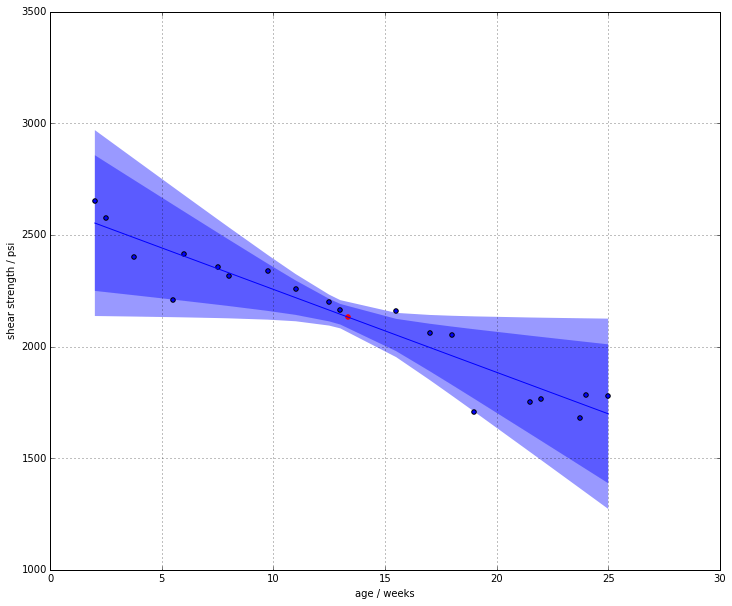

In [289]:
prop_sorted  = prop.sort('age')
scatter(prop_sorted.age, prop_sorted.shear_strength,zorder=40)
plot(prop_sorted.age, prop_sorted.fit,zorder=40)
scatter([prop.age.mean()], [prop.shear_strength.mean()], color='r', zorder=40) # show that fitted line goes through center-of-mass
grid()
xlabel('age / weeks')
ylabel('shear strength / psi')
fill_between(prop_sorted.age, prop_sorted.conf_lower_99, prop_sorted.conf_upper_99, alpha=0.4, linewidth=0, zorder=0)
fill_between(prop_sorted.age, prop_sorted.conf_lower_95, prop_sorted.conf_upper_95, alpha=0.4, linewidth=0, zorder=1)
#plot(prop_sorted.age, prop_sorted.conf_lower_95, 'b')
#plot(prop_sorted.age, prop_sorted.conf_upper_95, 'b')

It is very likely I'm calculating the intervals incorrectly. See
[statsmodels' implementation](https://github.com/statsmodels/statsmodels/blob/master/statsmodels/stats/outliers_influence.py) to understand how to do it right.


In [321]:
from statsmodels.stats.outliers_influence import summary_table
st, data, ss2 = summary_table(prop_fit, alpha=0.05)
fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

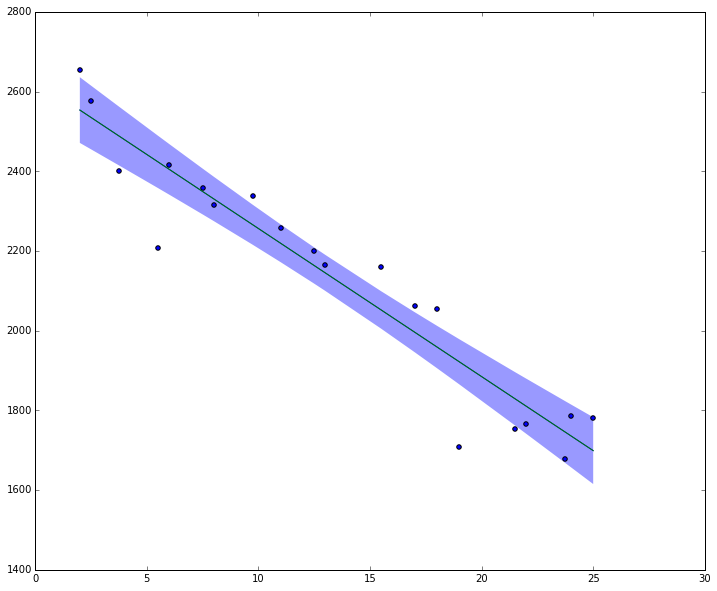

In [322]:
prop['mean_ci_low'] = predict_mean_ci_low
prop['mean_ci_upp'] = predict_mean_ci_upp
prop['fit'] = fittedvalues
prop_sorted = prop.sort('age')
plot(prop_sorted.age, prop_sorted.fit)

fill_between(prop_sorted.age, prop_sorted.mean_ci_low, prop_sorted.mean_ci_upp, alpha=0.4, linewidth=0, zorder=0)
scatter(prop_sorted.age, prop_sorted.shear_strength, zorder=40)
plot(prop_sorted.age, prop_sorted.fit, zorder=40)

## Hypothesis testing

If we knew the true variance $\sigma$, we could check the significance of our parameter fits using
$$Z_0 = \frac{\hat\beta_1 - \beta_{01}}{\sqrt{\sigma^2/S_{\text{xx}}}} \ \text{~} \  \text{NID}(0, 1)$$

Since we do not know $\sigma$, we use the estimator $\hat\sigma$. Knowing that $(n-2)\text{MS}_\text{E}/\sigma^2\ \text{~}\ \chi^2_{n-2}$ and that MSe and $\hat\beta_1$ are independent, the correct estimator to use is
$$t_0 = \frac{\hat\beta_1 - \beta_{01}}{\sqrt{\text{MS}_\text{E}/S_{\text{xx}}}}$$

It is t-distributed with n-2 degrees of freedom.

In [212]:
students_t.ppf(0.99, prop_fit.df_resid)
# basically, we can reject the hypothesis that there is no slope at the 99% confidence level.
# also, we can reject the hypothesis that the mean is zero at 99% level

2.5523796301794528

In [214]:
fdist.ppf(0.99, 1, 18)

8.2854195550996543

In [234]:
prop.age.var()

58.239967105263148